In [79]:
%load_ext autoreload
%autoreload 2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
from experiment_utils import set_env, seed_everything
set_env()
from cgn_framework.mnists.generate_data import generate_cf_dataset, generate_dataset, get_dataloaders

# Train concept classifier for double-colored-MNIST
We need to train:
1. A CF for classifying the digit's color
2. A CF for classifying the digit's shape
3. A CF for background color

## Load dataset

In [81]:
dl_train, dl_test = get_dataloaders('double_colored_MNIST', batch_size=1000, workers=8)

### Dataset size

In [82]:
print(f"Train: {dl_train.dataset.labels.shape[0]}")
print(f"Test: {dl_test.dataset.labels.shape[0]}")

Train: 50000
Test: 10000


### Get a sample image

In [93]:
random_idx = np.random.randint(0, dl_train.dataset.labels.shape[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


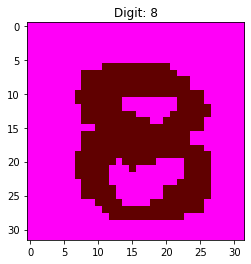

BG color: [[[254.54966735839844]], [[1.4238920211791992]], [[258.5576171875]]]
Obj color: [[[176.92726135253906]], [[50.06650924682617]], [[94.54214477539062]]]


In [95]:
plt.imshow(dl_train.dataset.__getitem__(random_idx)['ims'].transpose(0,1).transpose(1,2))
label = dl_train.dataset.__getitem__(random_idx)['labels']
plt.title(f"Digit: {label}")
plt.show()
print(f"BG color: {(dl_train.dataset.__getitem__(random_idx)['back_color']*255).tolist()}")
print(f"Obj color: {(dl_train.dataset.__getitem__(random_idx)['obj_color']*255).tolist()}")

## Train color CF

In [19]:
from cgn_framework.mnists.models.classifier import CNN

color_cf = CNN(num_classes=10, num_channels=3)

## Train shape CF

## Train background CF